Note Book de Análise de preço imobiliario

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import kagglehub
import subprocess
import os

from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# 1. Importar dados

Opções de fonte da dados:

    - 'a': aluguel coletado no ZapImoveis em 27 de Out
    - 'c': compra coletado no ZapImoveis em 27 de Out
    - 'b': Bengaluru House price data

In [27]:
fonte_dados = 'c'  # 'a', 'c', 'b'

if fonte_dados == 'a':
    df = pd.read_csv('aluguel_blumenau_25_10_27.csv')
elif fonte_dados == 'c':
    df = pd.read_csv('compra_blumenau_25_10_27.csv')
elif fonte_dados == 'b':
    if not os.path.exists("kangglehub_datasets"):  
        path = kagglehub.dataset_download("amitabhajoy/bengaluru-house-price-data")
        subprocess.run(["cp", "-r", path, "./kangglehub_datasets/"])
    df = pd.read_csv('kangglehub_datasets/Bengaluru_House_Data.csv')
df


,Localidade,Endereco,M2,Preco,R$/M2,Latitude,Longitude,Tipo,Quarto,Banheiro,Vaga
0,"Cobertura para comprar com 143 m², 3 quartos, ...",NaN,143.0,920000.0,6433.566434,-27.079758,-48.910080,Cobertura,3,3,4
1,"Apartamento para comprar com 27 m², 1 quarto, ...",NaN,27.0,390000.0,14444.444444,-27.079758,-48.910080,Apartamento,1,1,1
2,"Apartamento para comprar com 167 m², 3 quartos...",Rua Lauro Mueller,167.0,1100000.0,6586.826347,-26.929131,-49.063395,Apartamento,3,2,0
3,"Casa para comprar com 220 m², 3 quartos, 3 ban...",Rua Teófilo Otoni,220.0,530000.0,2409.090909,-26.902077,-49.091453,Casa,3,3,3
4,"Apartamento para comprar com 120 m², 2 quartos...",Rua Siderópolis,120.0,700000.0,5833.333333,-26.879532,-49.083560,Apartamento,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...
9635,Lote/Terreno para comprar com 9370 m² em Velha...,NaN,9370.0,1300000.0,138.740662,-27.079758,-48.910080,Lote/Terreno,0,0,0
9636,"Casa para comprar com 160 m², 3 quartos, 4 ban...",NaN,160.0,1190000.0,7437.500000,-27.079758,-48.910080,Casa,3,4,2
9637,Sala/Conjunto para comprar com 25186 m² em Ito...,NaN,25186.0,17580000.0,698.006829,-27.079758,-48.910080,Sala/Conjunto,0,0,0
9638,Lote/Terreno para comprar com 360 m² em Ponta ...,NaN,360.0,750000.0,2083.333333,-27.079758,-48.910080,Lote/Terreno,0,0,0


# 2. Limpa os dados

Drop colunas indesejadas

In [28]:
if fonte_dados == 'a' or fonte_dados == 'c':
    df.drop(columns=['Localidade', 'Endereco', 'R$/M2'], inplace=True)
#elif fonte_dados == 'b':

df

,M2,Preco,Latitude,Longitude,Tipo,Quarto,Banheiro,Vaga
0,143.0,920000.0,-27.079758,-48.910080,Cobertura,3,3,4
1,27.0,390000.0,-27.079758,-48.910080,Apartamento,1,1,1
2,167.0,1100000.0,-26.929131,-49.063395,Apartamento,3,2,0
3,220.0,530000.0,-26.902077,-49.091453,Casa,3,3,3
4,120.0,700000.0,-26.879532,-49.083560,Apartamento,2,3,2
...,...,...,...,...,...,...,...,...
9635,9370.0,1300000.0,-27.079758,-48.910080,Lote/Terreno,0,0,0
9636,160.0,1190000.0,-27.079758,-48.910080,Casa,3,4,2
9637,25186.0,17580000.0,-27.079758,-48.910080,Sala/Conjunto,0,0,0
9638,360.0,750000.0,-27.079758,-48.910080,Lote/Terreno,0,0,0


Exclui os tipos de Imóveis indesejados

In [29]:
tipos_list = df['Tipo'].unique()
print(f'{tipos_list}')

['Cobertura' 'Apartamento' 'Casa' 'Lote/Terreno' 'Sobrado'
 'Prédio/Edificio' 'Sala/Conjunto' 'Imóvel' 'Galpão/Depósito/Armazém'
 'Ponto' 'Kitnet/Conjugado' 'Fazenda/Sítio/Chácara' 'Flat'
 'Prédio/Edifício' 'Hotel/Motel/Pousada']


In [30]:
tipos_desejados = ['Cobertura', 'Apartamento', 'Casa', 'Sobrado', 'Kitnet/Conjugado',
                    'Flat']
df = df[df['Tipo'].isin(tipos_desejados)]
print(f'{df["Tipo"].unique()} \n Com tamanho {df.shape}')

['Cobertura' 'Apartamento' 'Casa' 'Sobrado' 'Kitnet/Conjugado' 'Flat'] 
 Com tamanho (6895, 8)


Exclui Out Liers

In [31]:
df = df[df['Preco'] < 10000000]
df = df[df['M2'] < 1000]
df = df[df['Banheiro'] < 10]
df = df[df['Vaga'] < 20]
df.reset_index(inplace=True, drop=True)
print(f'Após exclusão de outliers, tamanho {df.shape}')

Após exclusão de outliers, tamanho (6863, 8)


Exclui NA

In [32]:
print(df.isna().sum())
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

M2            0
Preco         0
Latitude     87
Longitude    87
Tipo          0
Quarto        0
Banheiro      0
Vaga          0
dtype: int64


Mostra o Box Plot dos dados

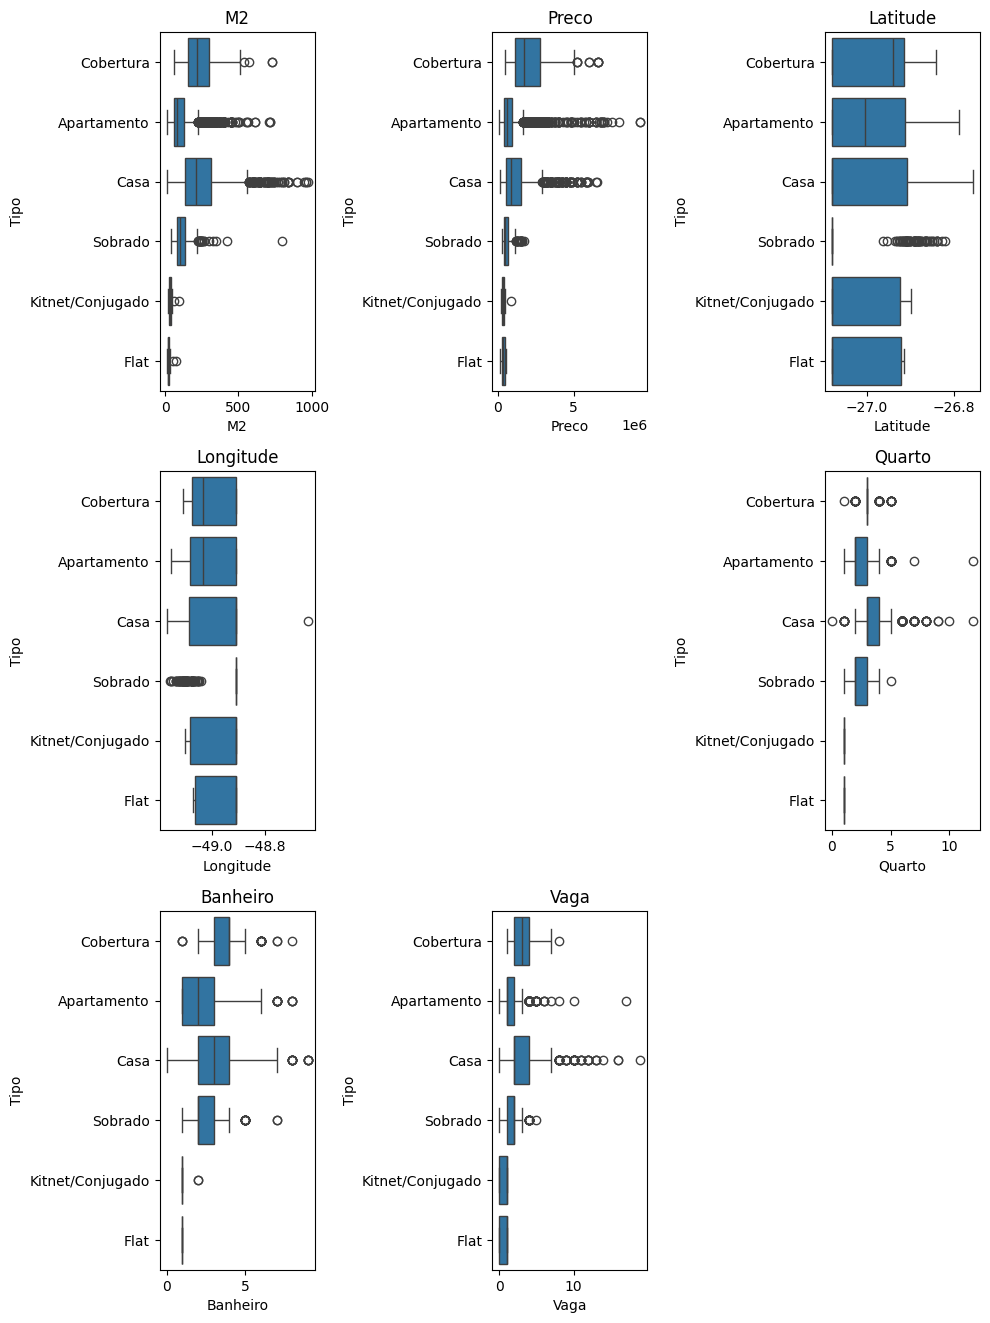

In [33]:
len_col = len(df.columns)
plt.figure(figsize=(10, len_col*5/3))


for idx, col in enumerate(df.columns):
    if col != 'Tipo':
        plt.subplot(int(len_col/3) + 1, 3, idx+1)

        sns.boxplot(data=df, x=col, y='Tipo')
        plt.title(f"{col}")
    #else:
plt.tight_layout()

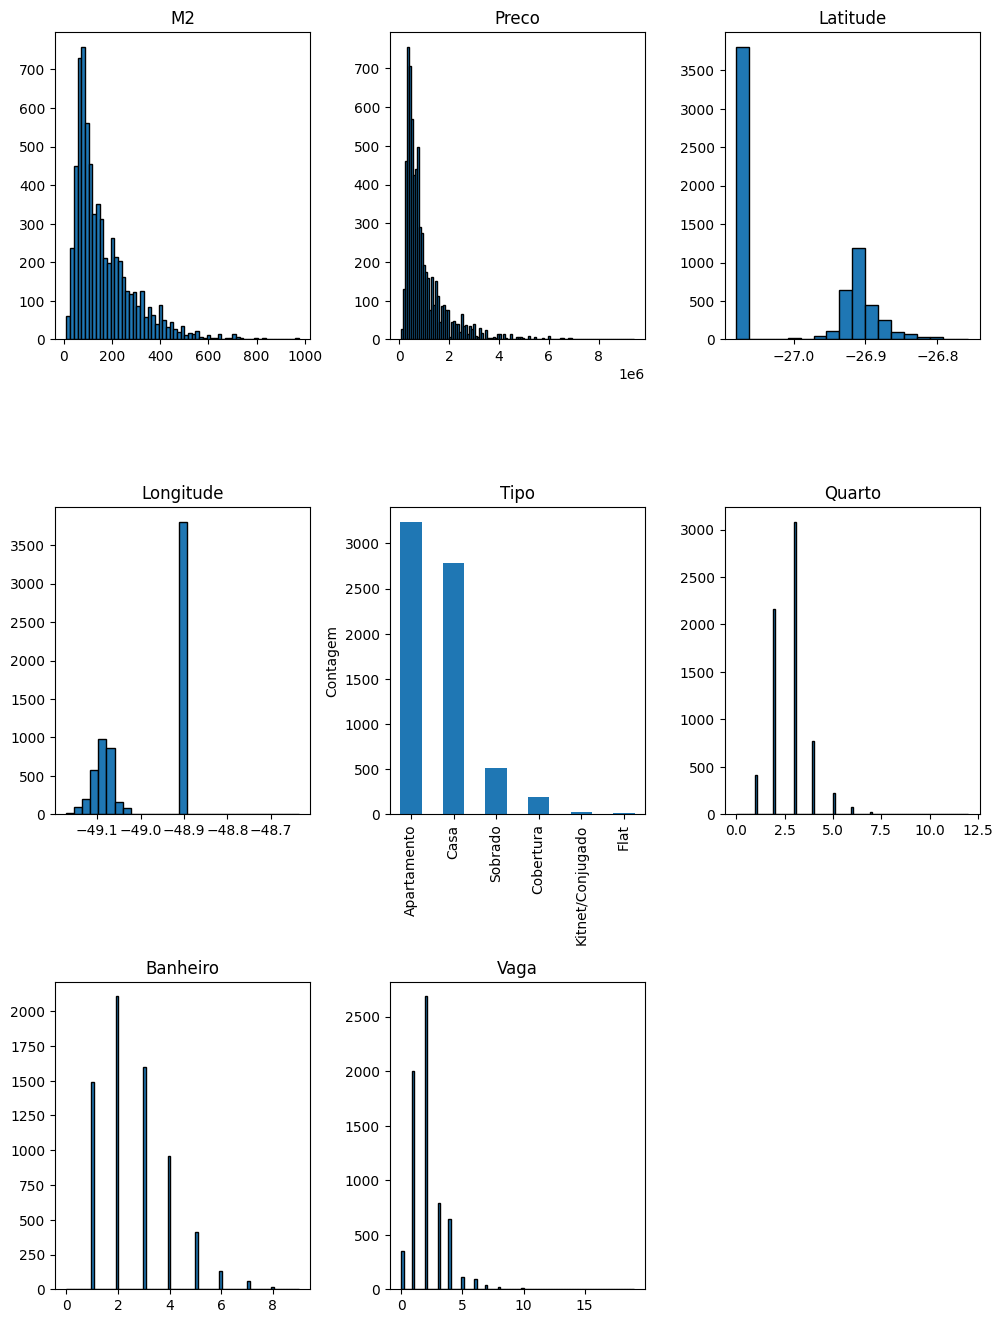

In [34]:
plt.figure(figsize=(10, len_col*5/3))

for idx, col in enumerate(df.columns):

    if col != 'Tipo':
        x = df[col].dropna()
        plt.subplot(int(len_col/3) + 1, 3, idx+1)
        bins = int((np.max(x) - np.min(x)) / (2 * (np.percentile(x, 75) - np.percentile(x, 25)) * len(x)**(-1/3)))
        plt.hist(x, bins=bins, edgecolor="black")
        plt.title(f"{col}")
    else:
        plt.subplot(int(len_col/3) + 1, 3, idx+1)
        df[col].value_counts(dropna=False).plot(kind="bar")
        plt.title(f"{col}")
        plt.ylabel("Contagem")
plt.tight_layout()

Transforma as colunas categóricas em One Hot Encoder

In [35]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df[df.columns.difference(['Preco'])], df['Preco'], test_size=0.2, stratify=df['Tipo'], random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42)

X_train_val.reset_index(inplace=True, drop=True)
X_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train_val.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_val.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [36]:
def convert_OHE(df):
    encoder = OneHotEncoder(sparse_output=False) 
    encoded = encoder.fit_transform(df['Tipo'].values.reshape(-1, 1))
    df_encoded = pd.DataFrame(
        encoded, 
        columns=encoder.get_feature_names_out(['Tipo'])
    )
    df = pd.concat([df, df_encoded], axis=1)
    df.drop(columns=['Tipo'], inplace=True)
    return df

In [37]:
if fonte_dados == 'b' or fonte_dados == 'c':
    
    X_train_val = convert_OHE(X_train_val)
    X_train = convert_OHE(X_train)
    X_val = convert_OHE(X_val)
    X_test = convert_OHE(X_test)

# 3. Aplica os algoritmos

## 3.1 xgBoost

In [13]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
map = mean_absolute_percentage_error(y_test, y_pred)
print(f'XGBoost - MAE: {mae}, MSE: {mse}, MAP: {map}')

XGBoost - MAE: 262780.7640694137, MSE: 241287236014.80588, MAP: 0.27870845034665714


In [14]:
pd.Series(xgb_model.feature_importances_, index=X_test.columns).sort_values(ascending=False)

Tipo_Casa                0.375714
M2                       0.163949
Banheiro                 0.097142
Tipo_Apartamento         0.091041
Tipo_Sobrado             0.066867
Vaga                     0.056378
Tipo_Cobertura           0.053461
Quarto                   0.044353
Longitude                0.024613
Latitude                 0.021687
Tipo_Kitnet/Conjugado    0.002881
Tipo_Flat                0.001914
dtype: float32

In [15]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 5, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.00001, 0.3),
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'tree_method': trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist'])      
    }

    xgb_model = xgb.XGBRegressor(**param)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)
best_params = study.best_params
print(f'Best parameters: {best_params}')

[I 2025-11-04 01:17:52,736] A new study created in memory with name: no-name-c344860d-530c-4d7c-b0f4-73f751442597
[I 2025-11-04 01:18:16,744] Trial 0 finished with value: 267326.957449262 and parameters: {'n_estimators': 423, 'max_depth': 15, 'learning_rate': 0.15963224616620603, 'booster': 'dart', 'tree_method': 'exact'}. Best is trial 0 with value: 267326.957449262.
[I 2025-11-04 01:18:23,393] Trial 1 finished with value: 245031.33642758304 and parameters: {'n_estimators': 273, 'max_depth': 7, 'learning_rate': 0.11507536848217594, 'booster': 'dart', 'tree_method': 'exact'}. Best is trial 1 with value: 245031.33642758304.
[I 2025-11-04 01:18:24,086] Trial 2 finished with value: 263819.7269733049 and parameters: {'n_estimators': 218, 'max_depth': 12, 'learning_rate': 0.15396775025844223, 'booster': 'gbtree', 'tree_method': 'hist'}. Best is trial 1 with value: 245031.33642758304.
[I 2025-11-04 01:18:24,332] Trial 3 finished with value: 260470.40825357471 and parameters: {'n_estimators':

Best parameters: {'n_estimators': 188, 'max_depth': 7, 'learning_rate': 0.16333019414603758, 'booster': 'dart', 'tree_method': 'exact'}


In [25]:
param = {'n_estimators': 188, 'max_depth': 7, 'learning_rate': 0.16333019414603758, 'booster': 'dart', 'tree_method': 'exact'}

xgb_model = xgb.XGBRegressor(**param)
xgb_model.fit(X_train_val, y_train_val)
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
map = mean_absolute_percentage_error(y_test, y_pred)
print(f'XGBoost - MAE: {mae}, MSE: {mse}, MAP: {map}')
print(pd.Series(xgb_model.feature_importances_, index=X_test.columns).sort_values(ascending=False))

XGBoost - MAE: 246204.8555033186, MSE: 218569713695.1147, MAP: 0.2668844402595169
Tipo_Casa                0.408469
M2                       0.136425
Tipo_Sobrado             0.104126
Tipo_Apartamento         0.100369
Banheiro                 0.073208
Vaga                     0.057235
Tipo_Cobertura           0.043554
Quarto                   0.038216
Longitude                0.021609
Latitude                 0.015740
Tipo_Flat                0.000899
Tipo_Kitnet/Conjugado    0.000151
dtype: float32


In [40]:
X_test

,Banheiro,Latitude,Longitude,M2,Quarto,Vaga,Tipo_Apartamento,Tipo_Casa,Tipo_Cobertura,Tipo_Flat,Tipo_Kitnet/Conjugado,Tipo_Sobrado
0,2,-26.912073,-49.115408,132.0,3,3,0.0,1.0,0.0,0.0,0.0,0.0
1,4,-26.936497,-49.143737,240.0,7,3,1.0,0.0,0.0,0.0,0.0,0.0
2,1,-27.079758,-48.910080,300.0,3,2,0.0,1.0,0.0,0.0,0.0,0.0
3,2,-27.079758,-48.910080,150.0,3,2,0.0,1.0,0.0,0.0,0.0,0.0
4,4,-26.917129,-49.093076,108.0,3,2,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1351,2,-27.079758,-48.910080,200.0,4,2,0.0,1.0,0.0,0.0,0.0,0.0
1352,2,-27.079758,-48.910080,115.0,3,2,0.0,0.0,0.0,0.0,0.0,1.0
1353,7,-27.079758,-48.910080,450.0,4,4,1.0,0.0,0.0,0.0,0.0,0.0
1354,1,-27.079758,-48.910080,120.0,2,1,0.0,1.0,0.0,0.0,0.0,0.0


## 3.2 Light GBM

In [16]:
lgbm_model = lgb.LGBMRegressor()
lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
map = mean_absolute_percentage_error(y_test, y_pred)
print(f'Light GBM - MAE: {mae}, MSE: {mse}, MAP: {map}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 4336, number of used features: 10
[LightGBM] [Info] Start training from score 1016087.407057
Light GBM - MAE: 262372.2600378639, MSE: 227368701368.20123, MAP: 0.2791068126963088


In [17]:
pd.Series(xgb_model.feature_importances_, index=X_test.columns).sort_values(ascending=False)

Tipo_Casa                0.375714
M2                       0.163949
Banheiro                 0.097142
Tipo_Apartamento         0.091041
Tipo_Sobrado             0.066867
Vaga                     0.056378
Tipo_Cobertura           0.053461
Quarto                   0.044353
Longitude                0.024613
Latitude                 0.021687
Tipo_Kitnet/Conjugado    0.002881
Tipo_Flat                0.001914
dtype: float32

In [18]:
def objective(trial):
    param = {
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf']),
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.00001, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000)

    }

    lgbm_model = lgb.LGBMRegressor(**param)
    lgbm_model.fit(X_train, y_train)
    y_pred = lgbm_model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)
best_params = study.best_params
print(f'Best parameters: {best_params}')

[I 2025-11-04 01:33:15,313] A new study created in memory with name: no-name-634a850f-ea59-4f85-a95c-c034a17318e8


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 4336, number of used features: 10
[LightGBM] [Info] Start training from score 1016087.407057


[I 2025-11-04 01:33:15,835] Trial 0 finished with value: 270825.22879725485 and parameters: {'boosting_type': 'gbdt', 'max_depth': 31, 'learning_rate': 0.29000782385003865, 'n_estimators': 871}. Best is trial 0 with value: 270825.22879725485.
[I 2025-11-04 01:33:15,874] Trial 1 finished with value: 253949.93055180283 and parameters: {'boosting_type': 'gbdt', 'max_depth': 47, 'learning_rate': 0.11535721601136882, 'n_estimators': 50}. Best is trial 1 with value: 253949.93055180283.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 4336, number of used features: 10
[LightGBM] [Info] Start training from score 1016087.407057
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 4336, number of used features: 10
[LightGBM] [Info] Start training from score 1016087.407057


[I 2025-11-04 01:33:16,058] Trial 2 finished with value: 250095.44663130192 and parameters: {'boosting_type': 'dart', 'max_depth': 38, 'learning_rate': 0.27379054541694686, 'n_estimators': 189}. Best is trial 2 with value: 250095.44663130192.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 4336, number of used features: 10
[LightGBM] [Info] Start training from score 1016087.407057


[I 2025-11-04 01:33:16,441] Trial 3 finished with value: 259006.59964840053 and parameters: {'boosting_type': 'gbdt', 'max_depth': 46, 'learning_rate': 0.09617995529520022, 'n_estimators': 660}. Best is trial 2 with value: 250095.44663130192.
[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[W 2025-11-04 01:33:16,446] Trial 4 failed with parameters: {'boosting_type': 'rf', 'max_depth': 39, 'learning_rate': 0.19733867757521362, 'n_estimators': 591} because of the following error: LightGBMError('Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .\n').
Traceback (most recent call last):
  File

LightGBMError: Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .


## 3.3 Random Forest

In [19]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
map = mean_absolute_percentage_error(y_test, y_pred)
print(f'Random Forest - MAE: {mae}, MSE: {mse}, MAP: {map}')

Random Forest - MAE: 265972.26097780705, MSE: 236927085093.48932, MAP: 0.28517168008606897


In [20]:
pd.Series(model.feature_importances_, index=X_test.columns).sort_values(ascending=False)

M2                       0.592304
Banheiro                 0.144419
Vaga                     0.073649
Tipo_Casa                0.047889
Quarto                   0.040777
Latitude                 0.035560
Longitude                0.034363
Tipo_Apartamento         0.019870
Tipo_Cobertura           0.006555
Tipo_Sobrado             0.004582
Tipo_Kitnet/Conjugado    0.000025
Tipo_Flat                0.000007
dtype: float64

In [21]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }

    model = RandomForestRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)
best_params = study.best_params
print(f'Best parameters: {best_params}')

[I 2025-11-04 02:17:32,132] A new study created in memory with name: no-name-c2c8ea2e-f75e-483d-8bd5-82ce2d173f58
[I 2025-11-04 02:17:33,708] Trial 0 finished with value: 290996.2032965737 and parameters: {'n_estimators': 503, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 0 with value: 290996.2032965737.
[I 2025-11-04 02:17:37,758] Trial 1 finished with value: 250304.4837142957 and parameters: {'n_estimators': 555, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 1 with value: 250304.4837142957.
[I 2025-11-04 02:17:39,918] Trial 2 finished with value: 266849.77714387735 and parameters: {'n_estimators': 491, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 1 with value: 250304.4837142957.
[I 2025-11-04 02:17:41,792] Trial 3 finished with value: 347075.6381394832 and parameters: {'n_estimators': 836, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 25030

Best parameters: {'n_estimators': 397, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1}


In [39]:
param = {'n_estimators': 397, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1}

model = RandomForestRegressor(**param)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
map = mean_absolute_percentage_error(y_test, y_pred)
print(f'Random Forest - MAE: {mae}, MSE: {mse}, MAP: {map}')
print(pd.Series(model.feature_importances_, index=X_test.columns).sort_values(ascending=False))

Random Forest - MAE: 261219.3423411922, MSE: 232370786843.97815, MAP: 0.2818561061091983
M2                       0.573230
Banheiro                 0.159559
Vaga                     0.075401
Tipo_Casa                0.050411
Quarto                   0.041780
Latitude                 0.034922
Longitude                0.033787
Tipo_Apartamento         0.019707
Tipo_Cobertura           0.006100
Tipo_Sobrado             0.005066
Tipo_Kitnet/Conjugado    0.000029
Tipo_Flat                0.000007
dtype: float64


# 4. Previsão do valor

In [45]:
x = pd.DataFrame(columns=X_test.columns)
x.loc[0] = {'Banheiro': 3, 'Latitude': -26.908588736369982, 'Longitude': -49.095866513551584, 'M2': 100, 'Quarto': 2, 'Vaga': 1,
            'Tipo_Apartamento': 0, 'Tipo_Casa': 0, 'Tipo_Cobertura': 0, 'Tipo_Flat': 0,
            'Tipo_Kitnet/Conjugado': 0, 'Tipo_Sobrado': 1}
y_pred_xgb = xgb_model.predict(x)

y_pred_rf = model.predict(x)

print(f'Previsão XGBoost: {(y_pred_xgb[0]/1000):.2f} mil')
print(f'Previsão Random Forest: {(y_pred_rf[0]/1000):.2f} mil')

Previsão XGBoost: 495.20 mil
Previsão Random Forest: 536.77 mil
